In [1]:
import pandas as pd
import numpy as np
import requests
import ujson
import os

import plotly
from plotly import tools

import plotly
with open('/Users/timlee/Dropbox/keys/plotly_apikey.txt','r') as f:
    api_key = f.read()
plotly.tools.set_credentials_file(username='tdlee', api_key=api_key)

import plotly.plotly as ply
import plotly.graph_objs as go
from plotly.grid_objs import Grid, Column

In [2]:
country_codes = ['chn', 'idn', 'ind', 'jpn', 'sau', 'tur', 'twn',
                 'bel', 'che', 'deu', 'esp', 'fra', 'gbr', 'ita',
                 'nld', 'pol', 'rus', 'swe', 'can', 'mex', 'usa',
                 'aus', 'arg', 'bra']


def get_countries_lkup():
    countries_url = 'https://atlas.media.mit.edu/attr/country/'
    resp = requests.get(countries_url)
    resp_json = ujson.loads(resp.content)['data']
    resp_df = pd.DataFrame(resp_json)
    country_id_lkup = {idx: name for idx, name in resp_df[['display_id','name']].values}
    return country_id_lkup


def get_data(countrycode):
    imports_url = './OEC_%s_imports.feather' % countrycode
    exports_url = './OEC_%s_exports.feather' % countrycode
    
    if not os.path.isfile(imports_url):
        return None, None
    
    if not os.path.isfile(exports_url):
        return None, None
        
    
    df_exports = pd.read_feather(exports_url)
    df_exports = df_exports[df_exports['export_val'].isna()==False].copy()
    df_exports = df_exports.sort_values(by='export_val')
    
    df_imports = pd.read_feather(imports_url)
    df_imports = df_imports[df_imports['import_val'].isna() == False].copy()
    df_imports = df_imports.sort_values(by = 'import_val')
    
    return df_imports, df_exports

def all_ports(country_codes):
    country_id_lkup = get_countries_lkup()
    import_collector = []
    export_collector = []
    for countrycode in country_codes:
        df_imports, df_exports = get_data(countrycode)
        if df_imports is not None:
            df_imp_tmp = df_imports[['year','product_name','import_val']].copy()
            df_imp_tmp['countrycode'] = countrycode
            df_imp_tmp['name'] = country_id_lkup[countrycode]
            df_exp_tmp = df_exports[['year','product_name','export_val']].copy()
            df_exp_tmp['countrycode'] = countrycode
            df_exp_tmp['name'] = country_id_lkup[countrycode]
            import_collector.append(df_imp_tmp)
            export_collector.append(df_exp_tmp)
        
    return pd.concat(import_collector), pd.concat(export_collector)



In [3]:
cc = pd.read_csv('countries.csv')
cc.head()

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


In [4]:
import_collector, export_collector = all_ports(country_codes)
import_df = import_collector.merge(cc, on='name', how='left')
export_df = export_collector.merge(cc, on='name', how='left')

### top products 2014

In [18]:
mask = import_df['year'] == 2014
top_50_import_prod = import_df.loc[mask].groupby('product_name')['import_val'].sum().sort_values(ascending=False)[:50].index

In [19]:
mask = export_df['year'] == 2014
top_50_export_prod = export_df.loc[mask].groupby('product_name')['export_val'].sum().sort_values(ascending=False)[:50].index

In [7]:
export_df.head()

,year,product_name,export_val,countrycode,name,country,latitude,longitude
0,2004.0,Semen bovine,1000.00,chn,China,CN,35.86166,104.195397
1,2011.0,"Sisal and Agave, processed but not spun, tow &...",1000.15,chn,China,CN,35.86166,104.195397
2,2002.0,"Logs, Beech (Fagus spp)",1018.92,chn,China,CN,35.86166,104.195397
3,2010.0,Typesetting equipment other than photo,1020.00,chn,China,CN,35.86166,104.195397
4,2008.0,"Frog legs, fresh, chilled or frozen",1026.43,chn,China,CN,35.86166,104.195397


### make a map

In [65]:
product_name = top_50_export_prod[35]

mask1 = export_df['product_name'] == product_name 
mask2 = export_df['year'] == 2014
mask = mask1 & mask2
df = export_df[mask].copy()
df['log_export_val'] = np.log(df['export_val'])
sizefield = 'export_val'
textfield = 'export_val'
adjustment = 1e-9

tr = go.Scattergeo(
    lon = df['longitude'].values,
    lat = df['latitude'].values,
    locationmode = 'country names',
    text = df['name'] + ' ' + sizefield + ': ' + df[textfield].astype(str),
    mode = 'markers',
    marker = dict(
        size = df[sizefield]*adjustment,
    ),
)

layout = dict(
    title = '%s Size:%s ' % (product_name, sizefield),
    geo = dict(
        scope = 'world',
        showframe = True,
        showcountries=True,
        showland = True,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=[tr], layout=layout )
ply.iplot( fig, validate=False, filename='wmap222225' )

### box plots

In [20]:
mask = import_df['year'] == 2014
top_20_import_prod = import_df.loc[mask].groupby('product_name')['import_val'].sum().sort_values(ascending=False)[:20].index

In [21]:
mask = export_df['year'] == 2014
top_20_export_prod = export_df.loc[mask].groupby('product_name')['export_val'].sum().sort_values(ascending=False)[:20].index 

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
sns.set(font_scale=2)

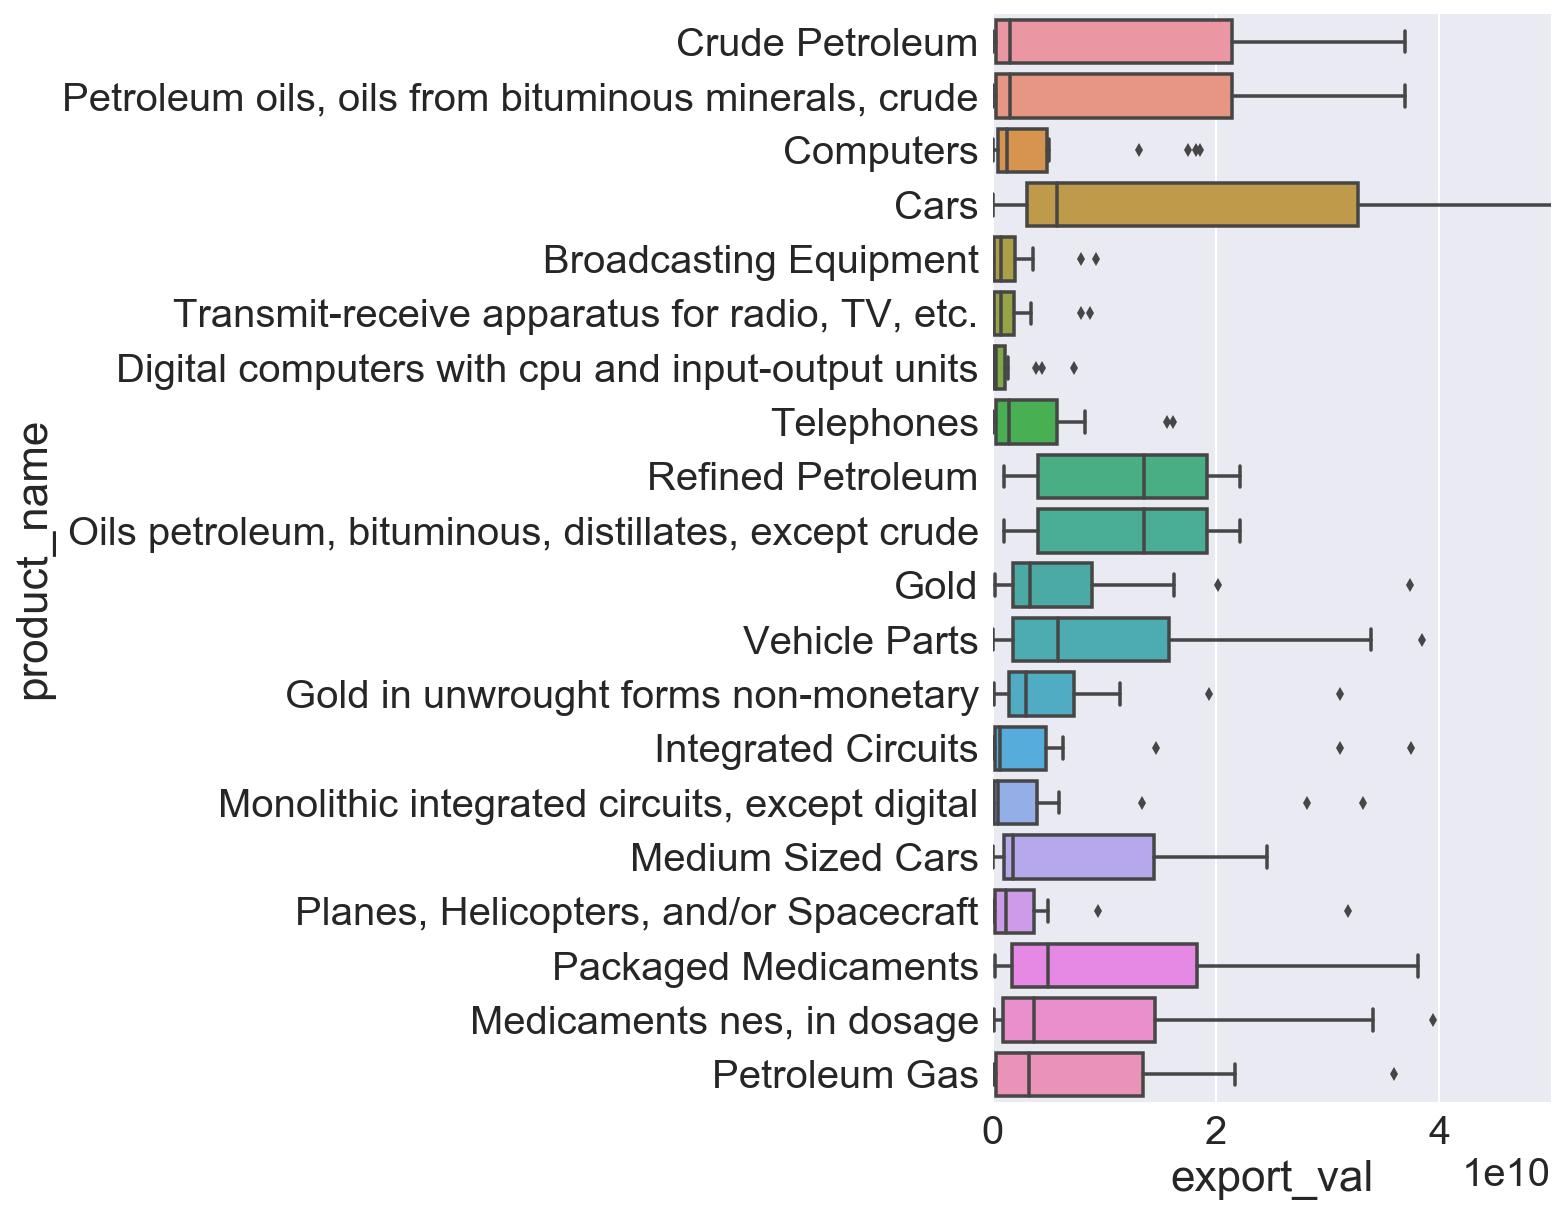

In [36]:
mask1 = export_df['product_name'].isin(top_20_export_prod)
mask2 = export_df['year'] == 2014
mask = mask1 & mask2
plt.figure(figsize=(5,10))
plt.xlim(0,5e10)
sns.boxplot(x='export_val', y= 'product_name',  data=export_df[mask].sort_values('export_val', ascending=False))

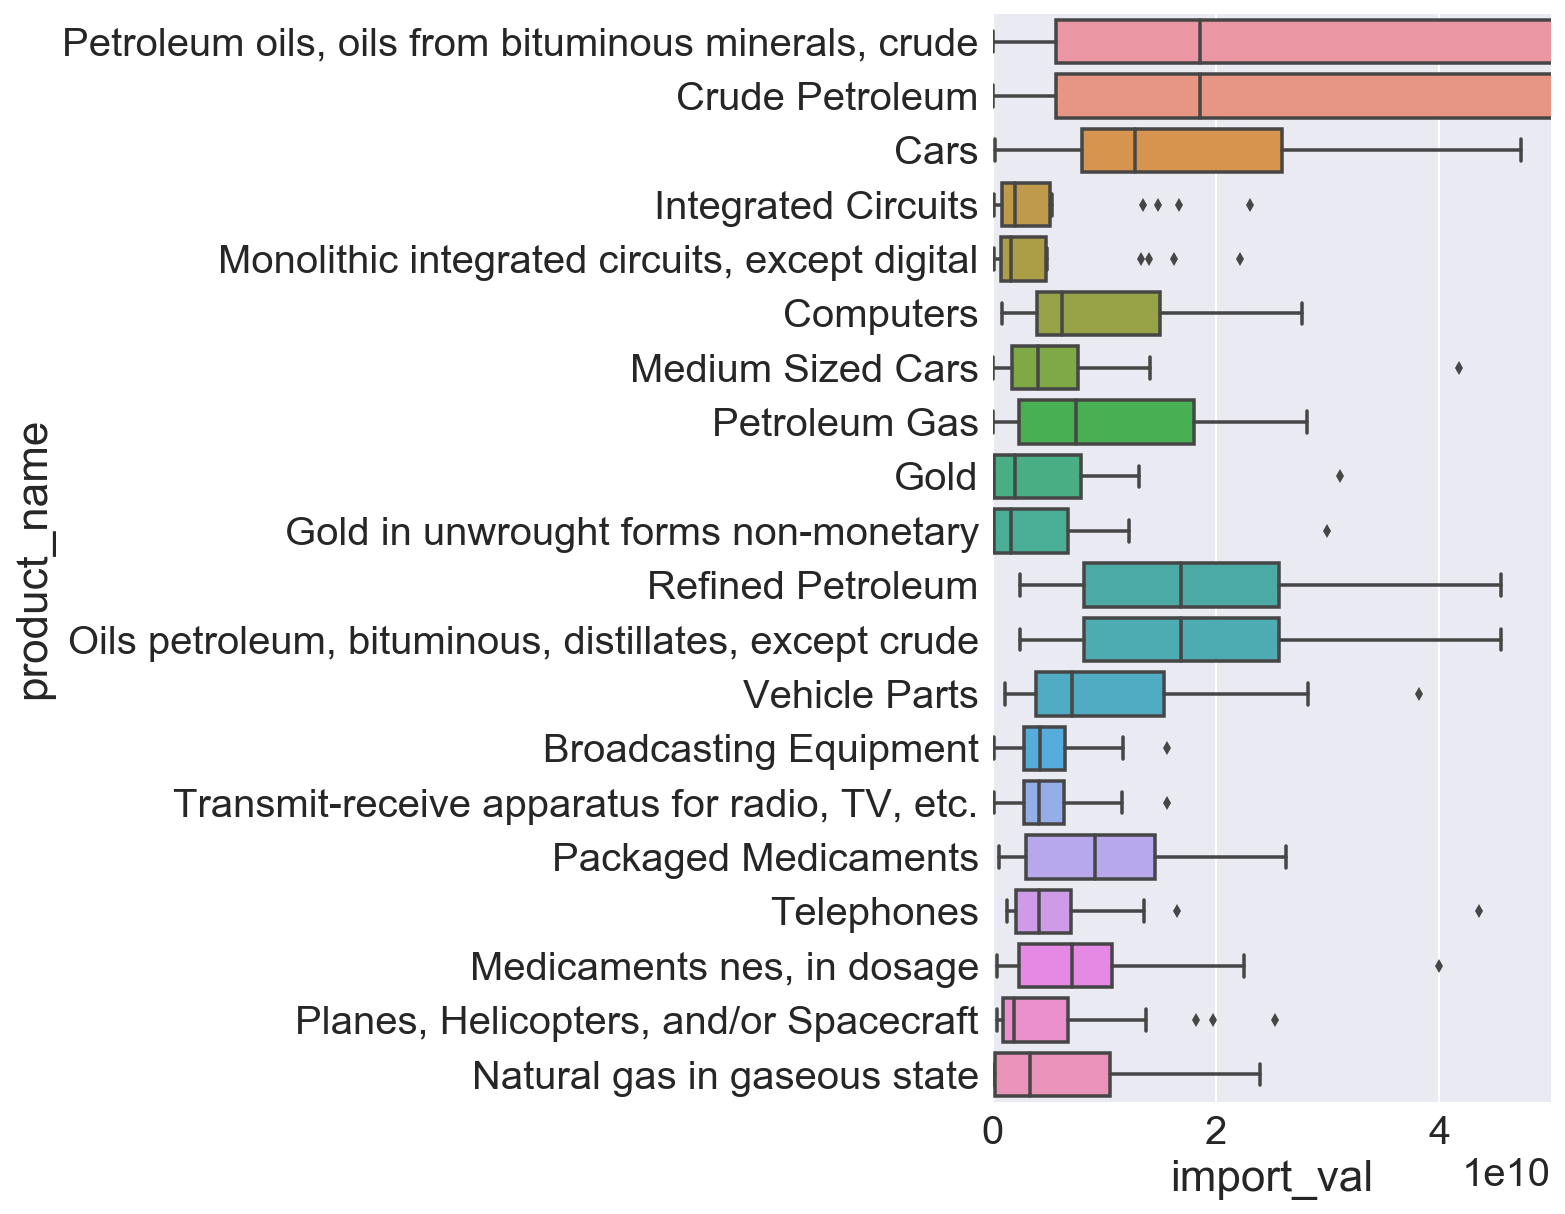

In [37]:
mask1 = import_df['product_name'].isin(top_20_import_prod)
mask2 = import_df['year'] == 2014
mask = mask1 & mask2
plt.figure(figsize=(5,10))
plt.xlim(0,5e10)
sns.boxplot(x='import_val', y= 'product_name',  data=import_df[mask].sort_values('import_val', ascending=False))